In [1]:
import numpy as np
import pandas as pd
import sys 
sys.path.append('/home/rosselli/GraRed')
from GraRed import Catalogue, model

In [2]:
%%time
dd =pd.read_parquet('/home/rosselli/GraRed/Data/WH15_cluster_cat.parquet')
m = 1.08*np.log10(dd.RL500.values) - 1.37 +14
dd['M500']=10**m
rand_gen = np.random.default_rng(1234)


dd = dd.loc[rand_gen.choice(dd.index,500,replace=False)]
cl = Catalogue.Cluster(dd['RA[deg]'].values,dd['Dec[deg]'].values,dd['z'].values,mass=dd['M500'].values,radius=dd['R500[Mpc]'].values,
concentration=None,compute_conc=True,is_crit=True, delta=500,gravity='GR', seed=1234)
cl.data

if the masses are in logharitmic scale, please change it or the code will not work
CPU times: user 1min 17s, sys: 2.44 s, total: 1min 19s
Wall time: 1min 15s


,ID,RA,Dec,redshift,M_500,Dc,Dm,R_500,c_500
0,0,121.07097,40.96972,0.5002,1.558703e+14,1947.088481,1947.088481,0.65,2.022359
1,1,152.55180,7.98580,0.4567,1.495051e+14,1799.018680,1799.018680,0.68,1.924187
2,2,343.95486,32.73777,0.4643,1.516044e+14,1825.168610,1825.168610,0.71,2.038161
3,3,240.42873,22.83217,0.4050,1.358822e+14,1617.938944,1617.938944,0.67,2.081555
4,4,28.18143,-4.14231,0.0945,6.059494e+13,409.329013,409.329013,0.61,2.590286
...,...,...,...,...,...,...,...,...,...
495,495,322.50192,4.71461,0.6011,1.452525e+14,2275.903491,2275.903491,0.61,1.687941
496,496,156.40155,36.26064,0.1218,6.695555e+13,524.023631,524.023631,0.59,2.859511
497,497,198.71535,27.47644,0.1980,9.838621e+13,835.571915,835.571915,0.62,1.896146
498,498,10.29061,10.50953,0.5234,1.258490e+14,2024.484307,2024.484307,0.62,2.037171


In [3]:
mask = np.log10(cl.data.M_500.values)>14.
mass = cl.data.M_500.values[mask]
bins=np.logspace(np.min(np.log10(mass)),np.max(np.log10(mass)),20)
hist,_=np.histogram(mass,bins)


mean_bin=np.empty(len(hist),dtype=float)
hist_dm=np.empty(len(hist),dtype=float)
error=np.empty(len(hist),dtype=float)

for i in range(len(hist)):
    hist_dm[i]=hist[i]/((bins[i+1]-bins[i]))
    mean_bin[i]=(bins[i]+bins[i+1])*0.5
    error[i]=np.sqrt(hist[i])/((bins[i+1]-bins[i]))
    
error=error/(hist_dm*np.log(10))
logbin=np.log10(mean_bin)
loghist=np.log10(hist_dm)

idx = np.isfinite(loghist)
loghist=loghist[idx]
logbin=logbin[idx]
error=error[idx]

error

/tmp/ipykernel_935632/3332868403.py:16: RuntimeWarning: invalid value encountered in divide
  error=error/(hist_dm*np.log(10))
/tmp/ipykernel_935632/3332868403.py:18: RuntimeWarning: divide by zero encountered in log10
  loghist=np.log10(hist_dm)


array([0.0647408 , 0.05606718, 0.05560571, 0.06204207, 0.06701309,
       0.07238241, 0.09477083, 0.13094471, 0.13094471, 0.11607008,
       0.14476483, 0.21714724, 0.43429448, 0.43429448, 0.43429448,
       0.43429448, 0.30709257])

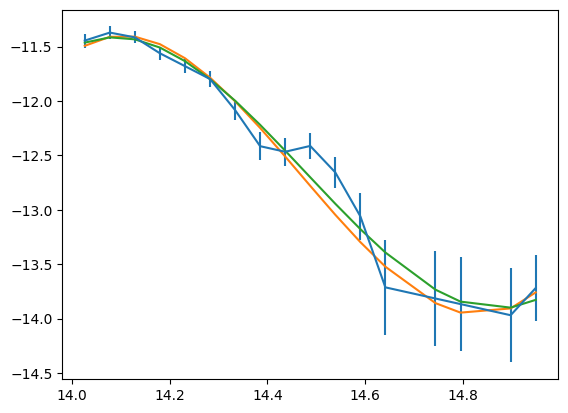

In [4]:


import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as spline

ff = spline(logbin,loghist,error)
f= spline(logbin,loghist)

plt.figure()
plt.errorbar(logbin,loghist,error)
plt.plot(logbin,ff(logbin))
plt.plot(logbin,f(logbin))



In [5]:
%%time
rr, redshift_gr,redshift_gr_td, finale, FR=model.compute_gra_red_gr_model(cl.data.redshift.values,
                                                                           cl.data.R_500.values,
                                                                           cl.data.M_500.values,
                                                                           cl.data.c_500.values,
                                                                           mass_func=ff,
                                                                           survey_lim_mag=22,compute_fr=True)

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 335 ms


In [6]:
%%time
rr_dgp, redshift_gr_dgp,redshift_gr_td_dgp, finale_dgp=model.compute_gra_red_DGP_model(cl.data.redshift.values,
                                                                           cl.data.R_500.values,
                                                                           cl.data.M_500.values,
                                                                           cl.data.c_500.values,
                                                                           mass_func=ff,
                                                                           survey_lim_mag=22)

/home/rosselli/.local/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


CPU times: user 16min 24s, sys: 200 µs, total: 16min 24s
Wall time: 16min 24s


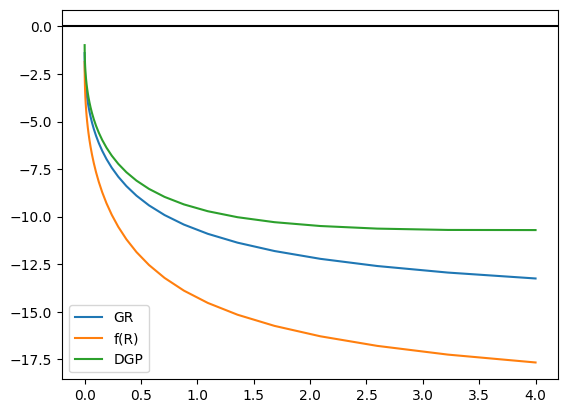

In [7]:
plt.figure()
plt.plot(rr,finale,label='GR')
plt.plot(rr,FR,label='f(R)')
plt.plot(rr_dgp,finale_dgp,label='DGP')
plt.axhline(0,c='k')
plt.legend()
plt.show()